# Modelando la Pandemia

  En este proyecto vamos a estudiar y analizar los datos mundiales de la pandemia COVID-19 usando países modelo de distintas políticas públicas para luego interpretar otras curvas.

Puedes descargar el dataset de casos totales, divididos por país [aquí.](
https://ourworldindata.org/coronavirus-data?country=
) Descarga los datos  formato .csv luego podrás cargarlos en el notebook usando pandas, a partir de eso selecciona los de los países que te interesan, hay un ejemplo de cómo se hace esto en este notebook. 

# ¿Cómo empezó la pandemia?


  La primer parte del trabajo consiste en estudiar cómo se empieza a propagar la pandemia, luego analizaremos las medidas tomadas y su efectividad.

  Al inicio de una pandemia, se estima que los contagios siguen una ley exponencial, esa es la fase de "crecimiento exponencial", luego hay un decaimiento dado por la inmunidad. 

  Los datos de casos confirmados en función del tiempo $C(t)$, pueden aproximarse con el modelo

$C(t)=e^{k(t-t_0)}$

donde $t_0$ es la fecha del primer contagio, y $k$ es un parámetro propio de cada enfermedad, que habla de la contagiosidad. Cuanto mayor es $k$, más grande será el número de casos confirmados dado por la expresión. $k$ depende de el tiempo que una persona enferma contagia, el nivel de infecciosidad del virus y cuántas personas que se pueden contagiar ve una persona enferma por día. Es decir, la circulación. Haciendo cuarententa, $k$ disminuye, con la circulación $k$ aumenta.

  El parámetro $k$ está directamente relacionado con el $R$ del que tanto se habla en los medios. En este proyecto haremos foco en $k$, pero puedes profundizar sobre esto si quieres, empezandó por [aquí](https://es.wikipedia.org/wiki/Ritmo_reproductivo_b%C3%A1sico). 

  Es posible hacer un modelo completo, pero para eso es necesario utilizar ecuaciones diferenciales. Si quieres profundizar sobre eso, busca información sobre "modelo epidemiológico SEIR". Si quieres ver cómo funciona este modelo, puedes empezar por [aquí](http://gabgoh.github.io/COVID/index.html). En ese link está implementado el modelo SEIR (no es necesario entender las ecuaciones en este caso) y el rol que cumplen los parámetros, puedes explorar el impacto de variar $R$ y el resto de los valores para ver cómo impactan en la cirva de contagios. Ahora utilizaremos la siguiente expresión para describir únicamente la etapa de crecimiento exponencial.


  Comienza estudiando cómo se distribuyó el $k$ inicial de la pandemia y si es posible elaborar un intervalo de confianza razonable para este valor. Para eso 
  
  1. Elegir diez países del norte (ahí empezó la pandemia) y puedes mide el valor de $k$ inicial de la pandemia, analizando datos del primer tramo.

  2. Analiza si es posible estimar la evolución mundial de la pandemia a partir de lo que obtuviste. Para esto, puedes elaborar un intervalo de confianza para $k$ a partir de los que obtuviste y así generar un modelo nuevo, basado en la distribución de $k$. Luego compara el modelo con los datos mundiales.

3. Piensa qué significa que el modelo de "bien" o dé "mal" ¿qué indicadores de esto existen?. Luego discute en el informe por qué crees que dio así. Recuerda que es importante elegir bien la población de muestra. Piensa qué criterios puedes elegir para representar bien la población mundial que se contagió al inicio de la pandemia.
 
 # Evaluando estrategias

 Ahora que tienes una manera de obtener información de las curvas, puedes intentar evaluar las estrategias de acción y el comportamiento de las poblaciones, construyendo un clasificador binario. 
1. Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia que te interese estudiar, como pueden ser "la población hizo cuarententa" o "la población se vacunó".
2. Piensa qué indicadores de la curva pueden hablar del éxito de la política que quieres estudiar. Por ejemplo, si se tratase de evaluar el éxito de una cuarentena podría ser porcentaje de población  que se contagió o variación del valor de $k$ a partir de que se empezó a implementar esa medida. Elige al menos 3 indicadores.
3. Investiga sobre países que hayan aplicado o no esa política pública, para generar una base de datos. Por ejemplo, Brasil no hizo cuarentena y China hizo una muy estricta. Recuerda hacer una selección inteligente de la porción de datos de la curva de cada país que vas a analizar.
4. Construye un clasificador binario a partir de una regresión logística o usando Naive Bayes para intentar analizar la estrategia de otros países y ver si es posible predecirla a partir de la curva de contagios y el clasificador. Un posible clasificador binario es uno que clasifique el porcentaje de contagios en función da las categorías "la población hizo cuarentena" y "la población n hizo cuarentena". Haz esto para los 3 indicadores que elegiste en el punto 3 y compara los resultados.
5. Elabora un informe con lo que hayas aprendido a lo largo de este proyecto, donde discutas la utilidad o no de los indicadores que elegiste y del análisis estadístico propuesto.

#¡Comencemos!

  A continuación dejamos un ejemplo de cómo extraer el $k$ inicial de Argentina, usando un ajuste de cuadrados mínimos. Si necesitas los datos mundiales, en la columna de países aparecen como "World".



In [1]:
import numpy as np
import pandas as pd
import pylab as plt
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D, axes3d
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [3]:
#cargamos los datos

# drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
# root_dir = "/content/gdrive/My Drive/datos_acamica"

In [4]:
datos_originales=pd.read_csv('data/owid-covid-data.csv')
datos_originales.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [5]:
datos_originales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167246 entries, 0 to 167245
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    167246 non-null  object 
 1   continent                                   157238 non-null  object 
 2   location                                    167246 non-null  object 
 3   date                                        167246 non-null  object 
 4   total_cases                                 164205 non-null  float64
 5   new_cases                                   164076 non-null  float64
 6   new_cases_smoothed                          162090 non-null  float64
 7   total_deaths                                146327 non-null  float64
 8   new_deaths                                  146373 non-null  float64
 9   new_deaths_smoothed                         144269 non-null  float64
 

In [6]:
# datos_originales.dropna(subset = ['location', 'date', 'total_cases', 'new_cases', 'population','human_development_index'], 
#                how = 'any', 
#                inplace = True)

In [7]:
datos_originales.shape

(167246, 67)

In [8]:
datos_originales.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [9]:
valores_faltantes = datos_originales.isna().sum()
print(valores_faltantes)

iso_code                                        0
continent                                   10008
location                                        0
date                                            0
total_cases                                  3041
                                            ...  
human_development_index                     30237
excess_mortality_cumulative_absolute       161499
excess_mortality_cumulative                161499
excess_mortality                           161499
excess_mortality_cumulative_per_million    161499
Length: 67, dtype: int64


<AxesSubplot:>

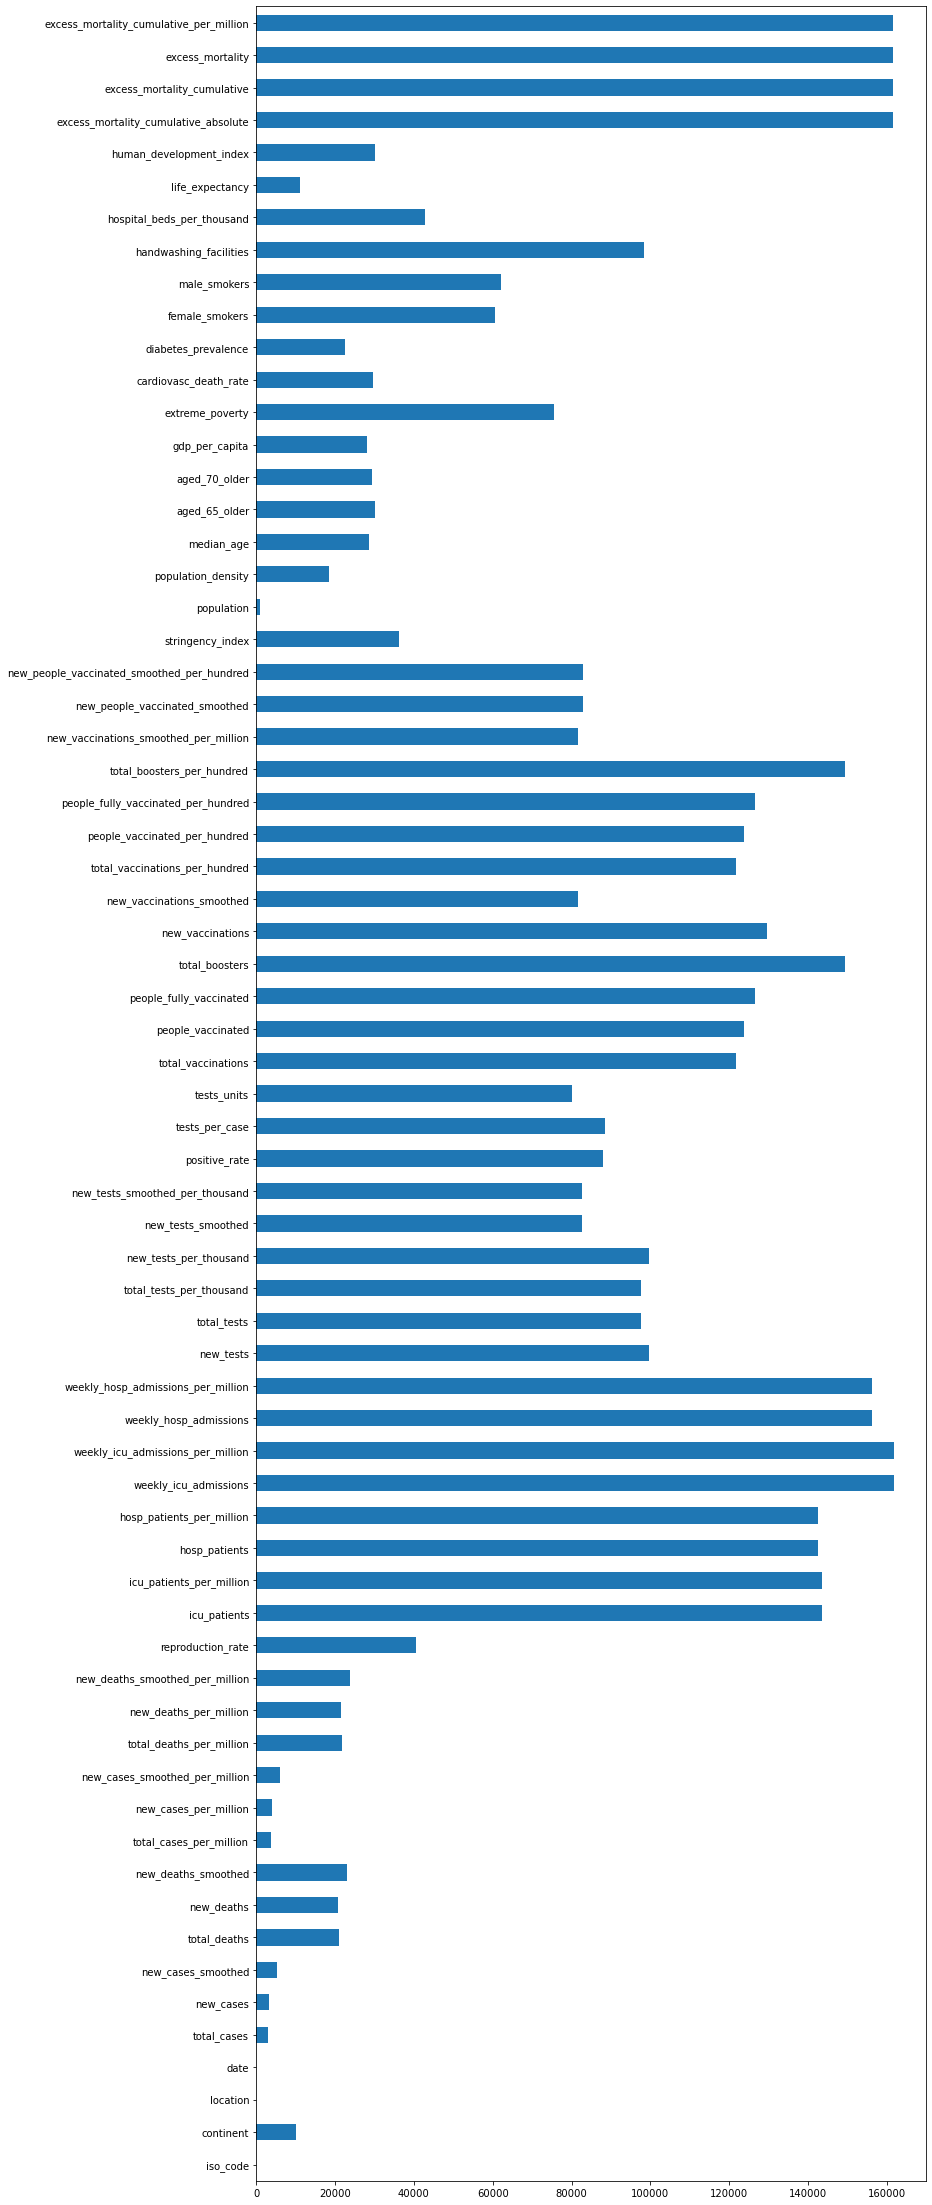

In [10]:
fig, ax = plt.subplots(figsize = (12, 40))
valores_faltantes.plot(kind = 'barh')

In [11]:
## Con esto nos damos cuenta que cuando el valor de 'continent' es NULO, es por que los valores de 
## 'location' tomaron los acumulados generalizados

datos_originales[datos_originales.continent.isnull()]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
745,OWID_AFR,NaN,Africa,2020-02-13,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,OWID_AFR,NaN,Africa,2020-02-14,1.0,1.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,OWID_AFR,NaN,Africa,2020-02-15,1.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748,OWID_AFR,NaN,Africa,2020-02-16,1.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
749,OWID_AFR,NaN,Africa,2020-02-17,1.0,0.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165100,OWID_WRL,NaN,World,2022-03-05,445230413.0,1363321.0,1515639.429,5995686.0,5480.0,7250.143,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
165101,OWID_WRL,NaN,World,2022-03-06,446383654.0,1153241.0,1528275.857,5999710.0,4025.0,7192.714,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
165102,OWID_WRL,NaN,World,2022-03-07,447882371.0,1498717.0,1541542.429,6007511.0,7801.0,7197.000,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN
165103,OWID_WRL,NaN,World,2022-03-08,449727293.0,1844922.0,1585029.286,6014690.0,7179.0,7059.143,...,6.434,34.635,60.13,2.705,72.58,0.737,NaN,NaN,NaN,NaN


In [12]:
## Vamos a crear un DF basado en el original para modificarlo

datos = datos_originales.copy()

In [13]:
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

Text(0, 0.5, 'cantidad de casos')

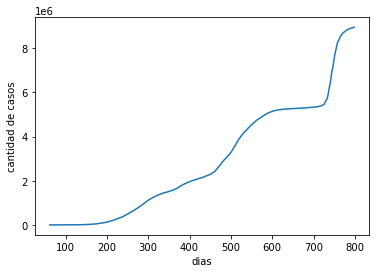

In [14]:
#seleccionamos Argentina

ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=confirmados[ind_arg]
dias_arg=np.arange(0,len(casos_arg))
plt.plot(dias_arg,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Esta es la curva de **casos totales** de Argentina. Aquí no se ven las olas, ya que estas se ven en la curva de casos confirmados por día, es decir, de casos nuevos. Esta habla de los acumulados, entonces siempre se agregan.

Para ver mejor la curva, podemos tomar el logartimo de los datos. Una curva exponencial se ve lineal en escala logarítmica


Text(0, 0.5, 'log cantidad de casos')

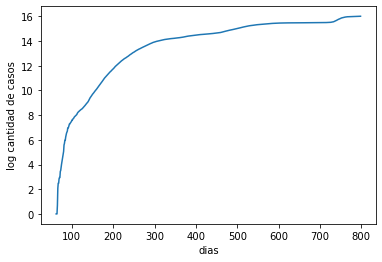

In [15]:
plt.plot(dias_arg,np.log(casos_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Veamos lo que pasa en los primeros 60 días desde que se detectó el primer caso en Argentina, para ver cómo fue el $k$ inicial

Text(0, 0.5, 'cantidad de casos')

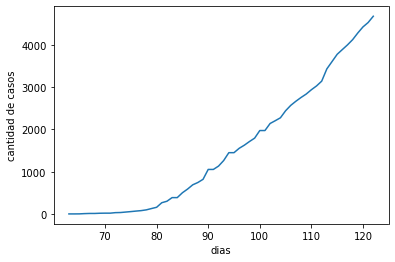

In [16]:
casos_principio_arg=casos_arg[63:123]
dias_principio_arg=dias_arg[63:123]

plt.plot(dias_principio_arg,casos_principio_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Es difícil determinar si esta parte es exponencial. Analicemos qué pasa en escala logarítmica.

Text(0, 0.5, 'log cantidad de casos')

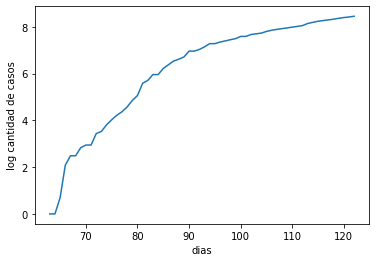

In [17]:

plt.plot(dias_principio_arg,np.log(casos_principio_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

Mejor nos quedamos con lo que sucede entre los días 95 y 115, ya que ese fue el comportamiento más sostenido.

Text(0, 0.5, 'cantidad de casos')

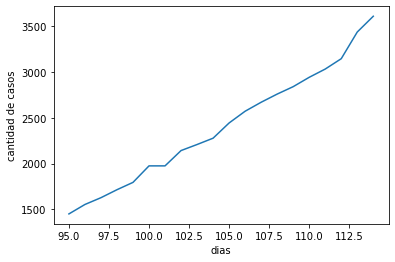

In [18]:
casos_principio_arg=casos_arg[95:115]
dias_principio_arg=dias_arg[95:115]

plt.plot(dias_principio_arg,casos_principio_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

Text(0, 0.5, 'log cantidad de casos')

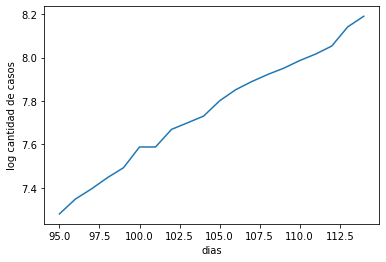

In [19]:
plt.plot(dias_principio_arg,np.log(casos_principio_arg))
plt.xlabel('dias')
plt.ylabel('log cantidad de casos')

¡Se ve bastante lineal! Aprovechemos esto para averiguar el $k$ utilizando un ajuste hecho con el método de cuadrados mínimos, ajustando los datos al modelo 

$Confirmados=e^{k(t-t_0)}$



In [20]:
#definimos función para ajustar modelo
def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

In [21]:
#ajustamos
popt, pcov = curve_fit(exponencial, dias_principio_arg, casos_principio_arg)
popt

array([ 4.46678539e-02, -6.90891363e+01])

Veamos cómo se ajusta lo que obtuvimos a los datos reales

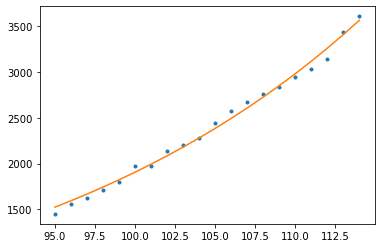

In [22]:
k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio_arg,k,t0)
plt.plot(dias_principio_arg,casos_principio_arg,'.')
plt.plot(dias_principio_arg,casos_simu)

Como última pista, hagamos una función que determine los casos nuevos por día a partir de estas curvas. Puede ser útil para tu análisis.

In [23]:
def casos_nuevos_arg(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos   

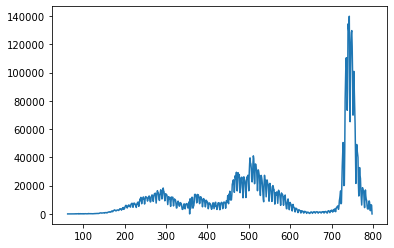

In [24]:
casos_arg=np.array(casos_arg)
nuevos_arg=casos_nuevos_arg(casos_arg)
plt.plot(nuevos_arg)

In [25]:
print(f"Para el caso de estudio inicial obtuvimos un valor de k igual a: {np.round(k,4)}")

Para el caso de estudio inicial obtuvimos un valor de k igual a: 0.0447


In [26]:
diario=datos['new_cases'] #carga vector todos los casos confirmados

Text(0, 0.5, 'cantidad de casos')

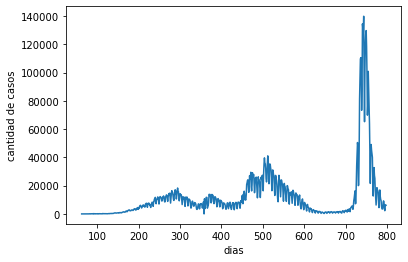

In [27]:
#seleccionamos Argentina

ind_arg=np.where(paises=='Argentina')
ind_arg=ind_arg[0]
casos_arg=diario[ind_arg]
dias_arg=np.arange(0,len(casos_arg))
plt.plot(dias_arg,casos_arg)
plt.xlabel('dias')
plt.ylabel('cantidad de casos')

### A. Continuamos el analisis con paises adicionales

In [28]:
## Primero es importante poder ver todos los paises disponibles en nuestra base

## paises_disponibles = datos['location'].unique()

for continent in datos["continent"].unique().tolist():
    if continent is not np.nan:
        print(f"En el continente de {continent} tenemos los siguientes paises:")
        print(f"{', '.join(datos.loc[datos['continent'] == continent, 'location'].unique())} \n")


En el continente de Asia tenemos los siguientes paises:
Afghanistan, Armenia, Azerbaijan, Bahrain, Bangladesh, Bhutan, Brunei, Cambodia, China, Georgia, Hong Kong, India, Indonesia, Iran, Iraq, Israel, Japan, Jordan, Kazakhstan, Kuwait, Kyrgyzstan, Laos, Lebanon, Macao, Malaysia, Maldives, Mongolia, Myanmar, Nepal, Northern Cyprus, Oman, Pakistan, Palestine, Philippines, Qatar, Saudi Arabia, Singapore, South Korea, Sri Lanka, Syria, Taiwan, Tajikistan, Thailand, Timor, Turkey, Turkmenistan, United Arab Emirates, Uzbekistan, Vietnam, Yemen 

En el continente de Europe tenemos los siguientes paises:
Albania, Andorra, Austria, Belarus, Belgium, Bosnia and Herzegovina, Bulgaria, Croatia, Cyprus, Czechia, Denmark, Estonia, Faeroe Islands, Finland, France, Germany, Gibraltar, Greece, Guernsey, Hungary, Iceland, Ireland, Isle of Man, Italy, Jersey, Kosovo, Latvia, Liechtenstein, Lithuania, Luxembourg, Malta, Moldova, Monaco, Montenegro, Netherlands, North Macedonia, Norway, Poland, Portugal, 

In [29]:
total_paises = datos["location"].unique().tolist()

In [30]:
##  Para este caso seleccionaremos China (teniendo en cuenta que aqui inicio la pandemia) y los demas paises del norte

countries = ['China', 'United States', 'Canada', 'United Kingdom', 'Sweden', 'Russia', 'Finland', 'Bahamas', 'Japan', 'Cuba']
paises_norte_k = np.array([])

paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

dias_limite_sup = 60
dias_limite_inf = 0

array([0.02274148, 0.33414979, 0.22301273, 0.15213423, 0.10482722,
       0.20641065, 0.12367441, 0.03375323, 0.07258429, 0.04538164])

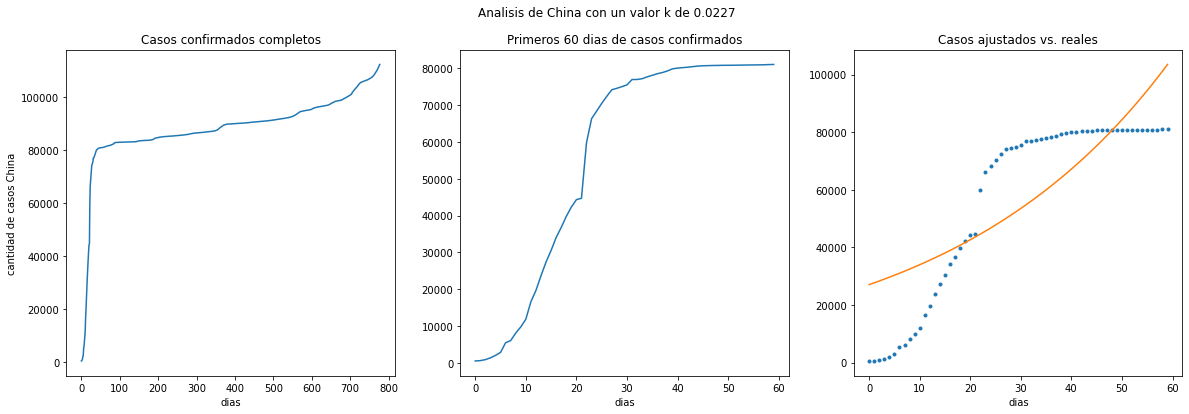

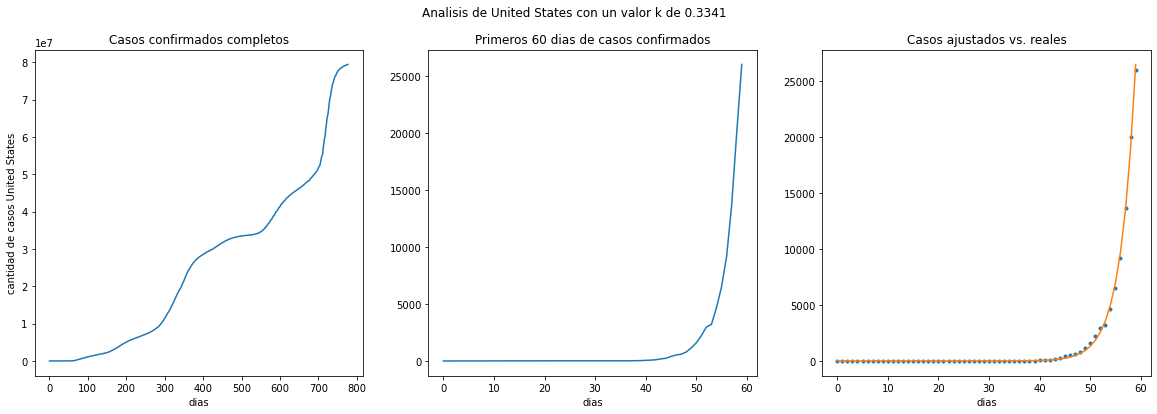

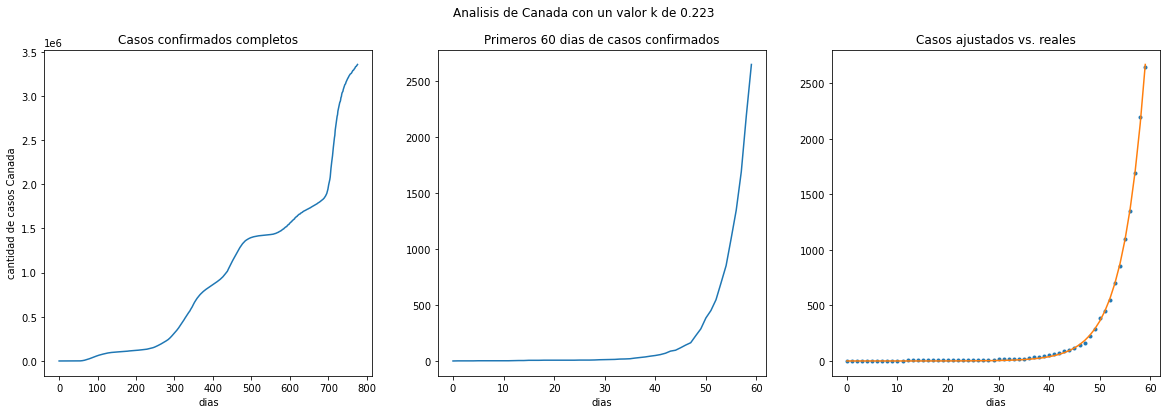

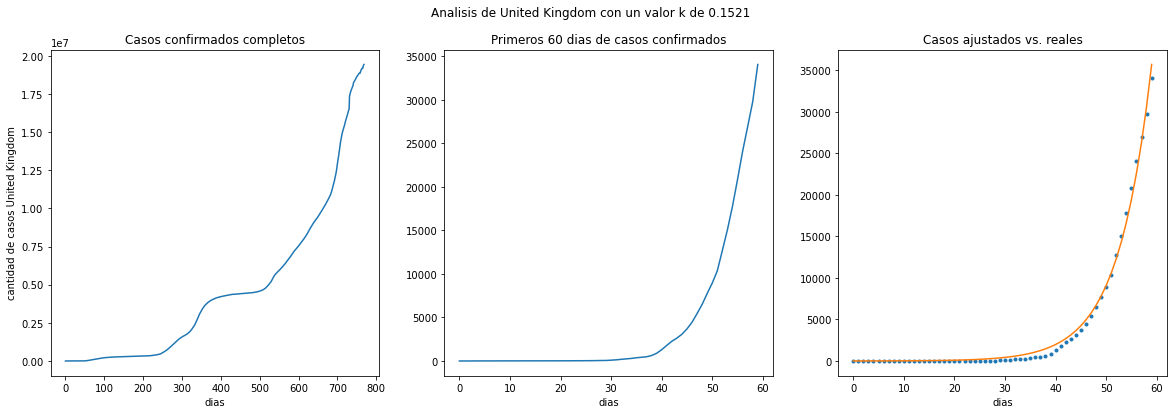

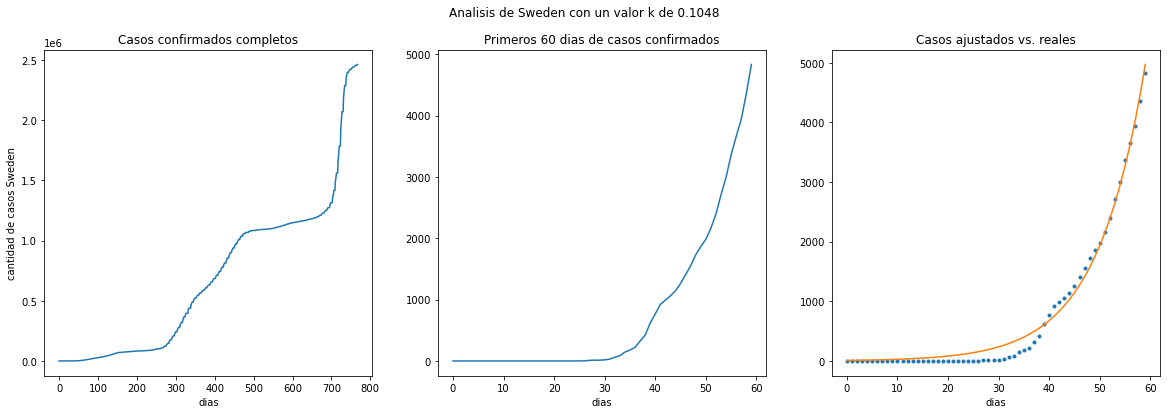

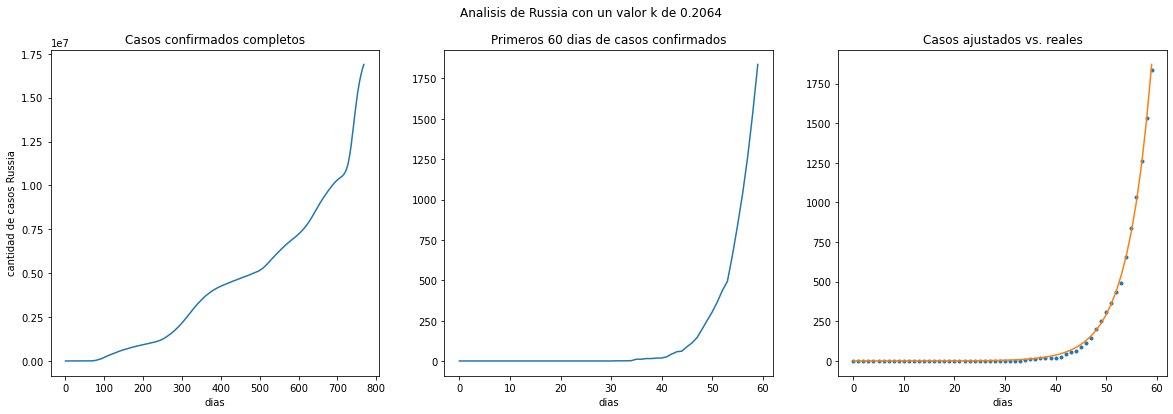

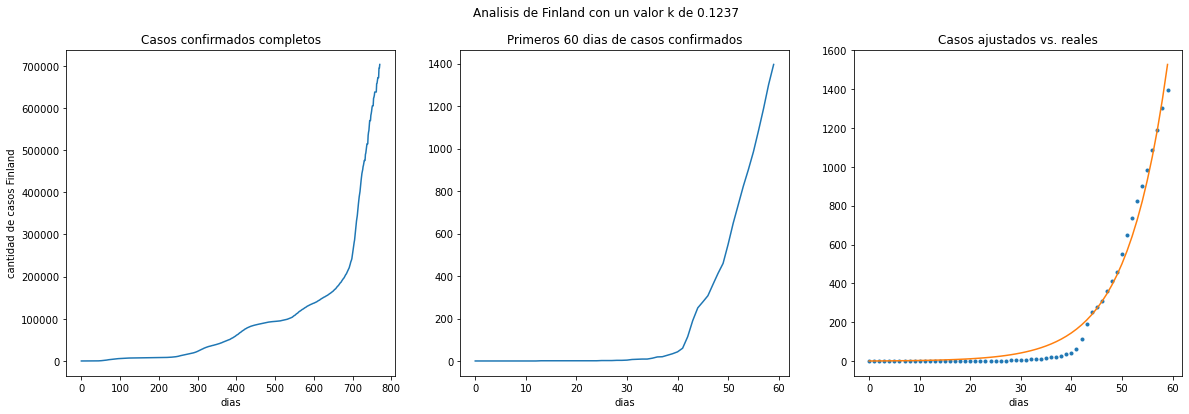

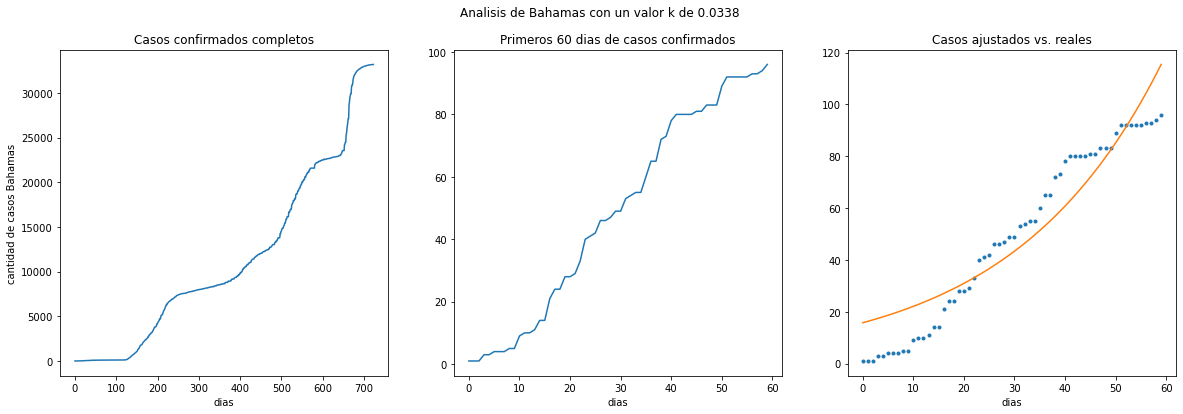

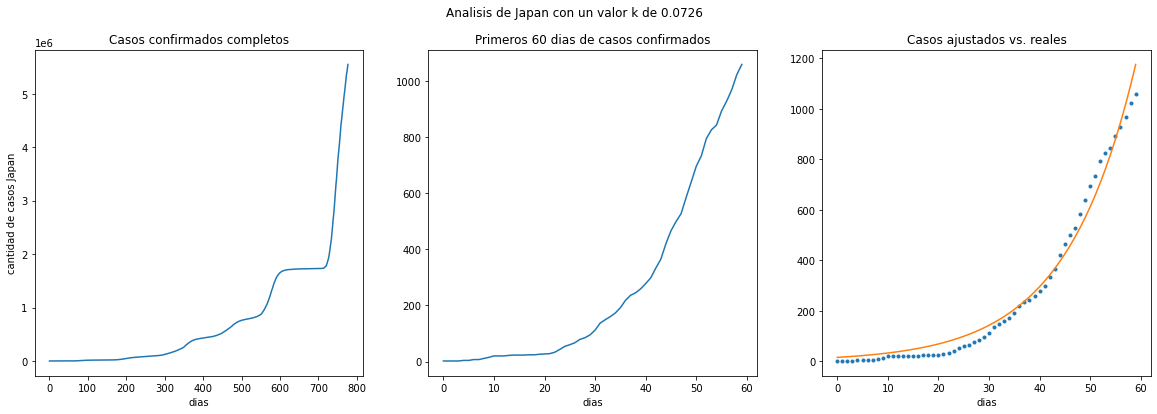

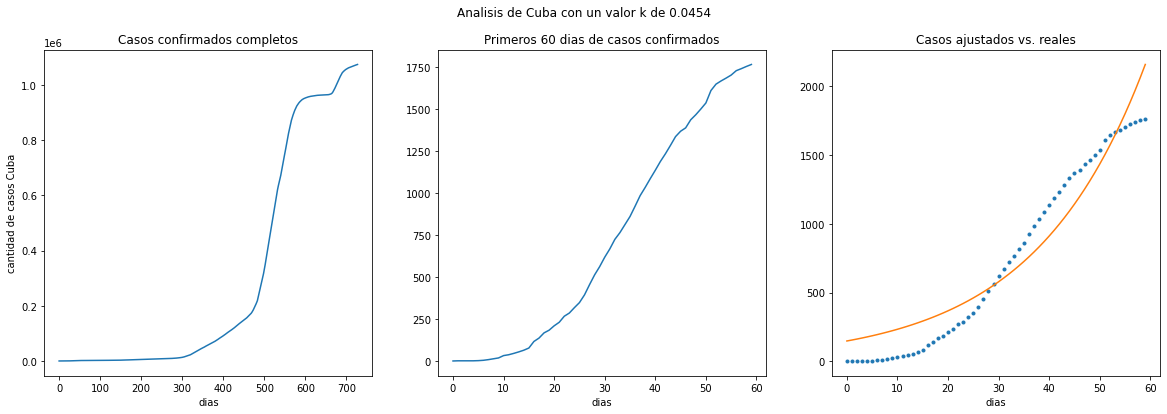

In [31]:

for country in countries:

    ind=np.where(paises==country)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].set_title('Casos confirmados completos')
    axs[0].plot(dias,casos)
    axs[0].set_xlabel('dias')
    axs[0].set_ylabel(f"cantidad de casos {country}")

    # En china los contagios arrancan desde el primer dia, y se analizaran sus primero 60 dias en donde se puede observar la tendencia del k inicial:
    casos_principio=casos[dias_limite_inf:dias_limite_sup]
    dias_principio=dias[dias_limite_inf:dias_limite_sup]
    
    axs[1].set_title(f'Primeros {dias_limite_sup} dias de casos confirmados')
    axs[1].plot(dias_principio,casos_principio)
    axs[1].set_xlabel('dias')

    #definimos función para ajustar modelo
    def exponencial(t,k,t0):
      C=np.exp(k*(t-t0))
      return C

    #ajustamos con el fin de encontrar los parametros optimos hallados (popt), y la matriz de covarianza de parametros hallados (pcov):
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=5000)

    k=popt[0]
    t0=popt[1]
    casos_simu=exponencial(dias_principio,k,t0)
    axs[2].set_title('Casos ajustados vs. reales')
    axs[2].plot(dias_principio,casos_principio,'.')
    axs[2].plot(dias_principio,casos_simu)
    axs[2].set_xlabel('dias')
    
    fig.suptitle(f"Analisis de {country} con un valor k de {np.round(k,4)}\n")

    paises_norte_k = np.append(paises_norte_k,k)
    
paises_norte_k

A pesar de lo inclinado que presenta ser la curva de *China*, logramos identificar que tambien logran desacelerar el contagio en su primer mes. Mientras que el resto de paises del norte comparten similitudes en su comportamiento y cierran sus primeros 60 dias con tendencia al alza, exceptuando por paises pequeños como *Cuba* y *Bahamas* que tiende levemente a desacelerar. Al mismo tiempo, destaca en esta metrica de los 60 dias, *EEUU* y *RU* como los paises que mas contagios logran en este periodo.

la curva exponencial no se ajusto al verdadero comportamiento de China, cuba y bahamas.... especialmente china]

**COMPLETAR LO ANTERIOR**

Se generara un intervalo de confianza para el valor de *k*, que se estima en 10 paises del norte analizados (los cuales se encuentran en la variable *paises_norte_k*), con el objetivo de representar la poblacion mundial. Para esto se usara la tecnica bootstraping o de resampling, buscando estimar un parametro y un error asociado, incluso cuando no es claro como es la distribucion de los datos. 

El siguiente paso, se logro, gracias a la ayuda de https://www.cienciadedatos.net/documentos/pystats04-bootstrapping-python.html

Se hallara la media y los intervalos de confianza de la siguiente forma:

In [32]:
# Por medio de las muestras que se obtuvieron del analisis de los 10 primeros paises del norte, se realizara el 
# metodo bootstrap con el fin de poder acercarse a la distribucion del estimador y poder obtener un intervalo de confianza 
# a partir del estimador que sera su media: 

def calcular_estadistico(x):
    estadistico = np.mean(x)
    
    return(estadistico)

In [33]:
# Se tomaran 9999 muestras de los k analizados en los primeros 10 paises del norte por el metodo de remuestreo, 
# de la siguiente manera:

def bootstraping(x, fun_estadistico, n_iteraciones=9999):
   
    n = len(x)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        resample = np.random.choice(x, size=n, replace=True)
        dist_boot[i] = fun_estadistico(resample)
        
    return dist_boot

In [34]:
# Es aqui donde usamos la variable "paises_norte_k" en donde tenemos guardados los valores obtenidos de cada pais

from tqdm import tqdm

dist_boot_norte = bootstraping(x = paises_norte_k,
                               fun_estadistico = calcular_estadistico,
                               n_iteraciones   = 9999)

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 20010.08it/s]


In [35]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles_norte = np.quantile(a = dist_boot_norte, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles_norte)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[0.07817983 0.19305066]


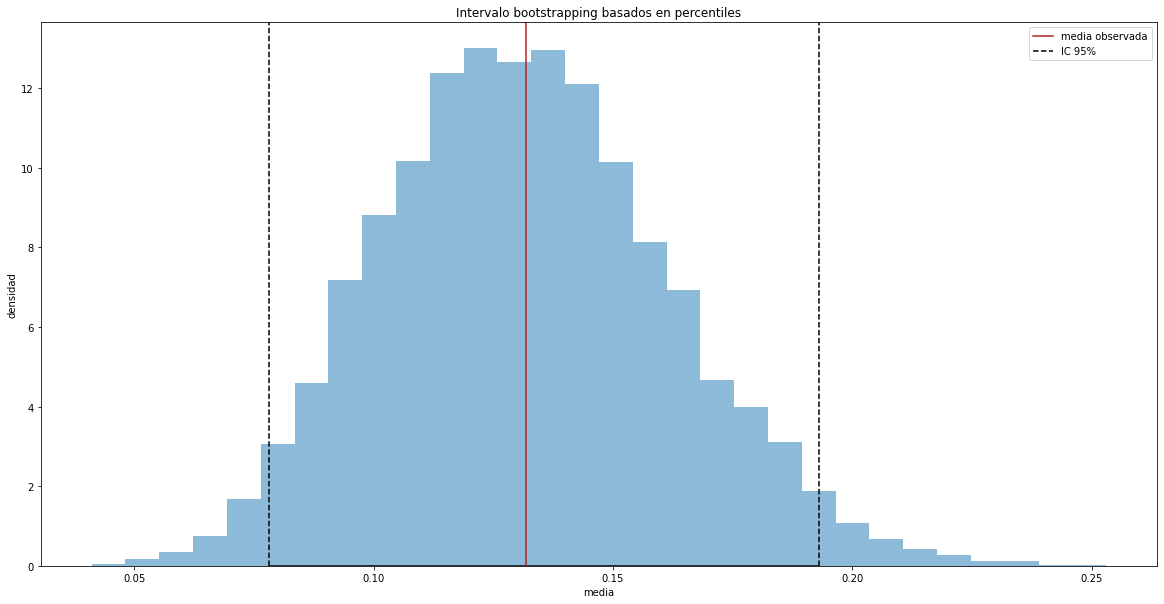

In [36]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,10))
ax.hist(dist_boot_norte, bins=30, density=True, alpha=0.5)
ax.axvline(x=paises_norte_k.mean(), color='firebrick', label='media observada')
ax.axvline(x=cuantiles_norte[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles_norte[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles_norte[0], xmax=cuantiles_norte[1], color='black')
ax.set_title('Intervalo bootstrapping basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

En este punto hacemos el mismo ejercicio para la data acotada que tenemos en nuesta base categorizada como *World* y de esta forma comprobar si en efecto el valor *k* generado a partir de los paises del norte es suficientemente representativo para el resto del mundo.

In [37]:
##  Para este caso seleccionaremos World

countries = ['World']
world_k = 0

paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

dias_limite_sup = 60
dias_limite_inf = 0

0.05133573633666548

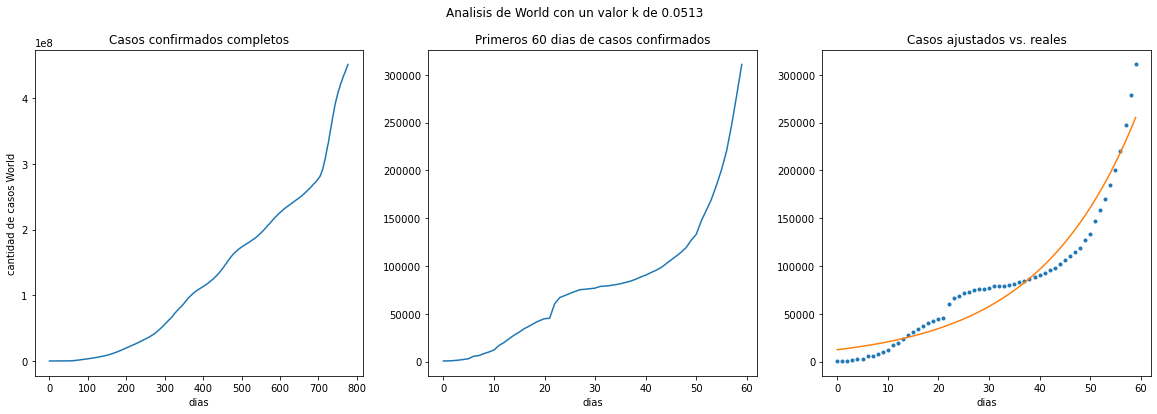

In [38]:

for country in countries:

    ind=np.where(paises==country)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].set_title('Casos confirmados completos')
    axs[0].plot(dias,casos)
    axs[0].set_xlabel('dias')
    axs[0].set_ylabel(f"cantidad de casos {country}")

    # En china los contagios arrancan desde el primer dia, y se analizaran sus primero 60 dias en donde se puede observar la tendencia del k inicial:
    casos_principio=casos[dias_limite_inf:dias_limite_sup]
    dias_principio=dias[dias_limite_inf:dias_limite_sup]
    
    axs[1].set_title(f'Primeros {dias_limite_sup} dias de casos confirmados')
    axs[1].plot(dias_principio,casos_principio)
    axs[1].set_xlabel('dias')

    #definimos función para ajustar modelo
    def exponencial(t,k,t0):
      C=np.exp(k*(t-t0))
      return C

    #ajustamos con el fin de encontrar los parametros optimos hallados (popt), y la matriz de covarianza de parametros hallados (pcov):
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=5000)

    k=popt[0]
    t0=popt[1]
    casos_simu=exponencial(dias_principio,k,t0)
    axs[2].set_title('Casos ajustados vs. reales')
    axs[2].plot(dias_principio,casos_principio,'.')
    axs[2].plot(dias_principio,casos_simu)
    axs[2].set_xlabel('dias')
    
    fig.suptitle(f"Analisis de {country} con un valor k de {np.round(k,4)}\n")

    world_k = k
    
world_k

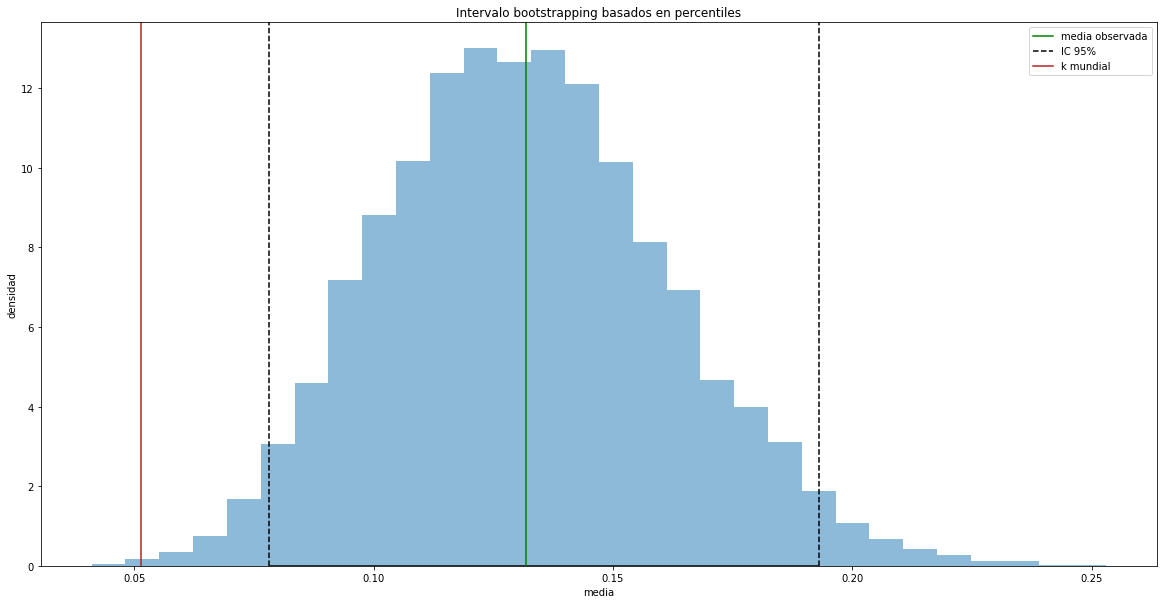

In [39]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,10))
ax.hist(dist_boot_norte, bins=30, density=True, alpha=0.5)
ax.axvline(x=paises_norte_k.mean(), color='green', label='media observada')
ax.axvline(x=cuantiles_norte[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles_norte[1], color='black', linestyle='--')
ax.axvline(x=world_k, color='firebrick', label='k mundial')
ax.hlines(y=0.001, xmin=cuantiles_norte[0], xmax=cuantiles_norte[1], color='black')
ax.set_title('Intervalo bootstrapping basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Con lo anterior se puede observar que los 10 paises elegidos **NO** son representativos (en los primeros 60 dias) de acuerdo a los intervalos de confianza obtenidos y el k mundial el cual queda por fuera del intervalo. 

In [40]:
print(f"Para un 95% de confiabilidad, los intevalos de confianza para k en los paises del norte son: {cuantiles_norte} \ny el k mundial obtenido es: {np.round(world_k,4)}")

Para un 95% de confiabilidad, los intevalos de confianza para k en los paises del norte son: [0.07817983 0.19305066] 
y el k mundial obtenido es: 0.0513


Por lo que se analizaran los paises del sur:

In [41]:
##  Para este caso seleccionaremos mas paises y muchos mas diveros de diferentes 

countries = ['Colombia', 'Venezuela', 'Brazil', 
             'Ecuador', 'Peru', 'Chile', 
             'Uruguay', 'Honduras', 'Japan',
             'Angola']
paises_varios_k = np.array([])

paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

dias_limite_sup = 60
dias_limite_inf = 0

array([0.0588232 , 0.03118727, 0.08453696, 0.08768218, 0.08495863,
       0.07194001, 0.02454559, 0.0675919 , 0.07258429, 0.03414532])

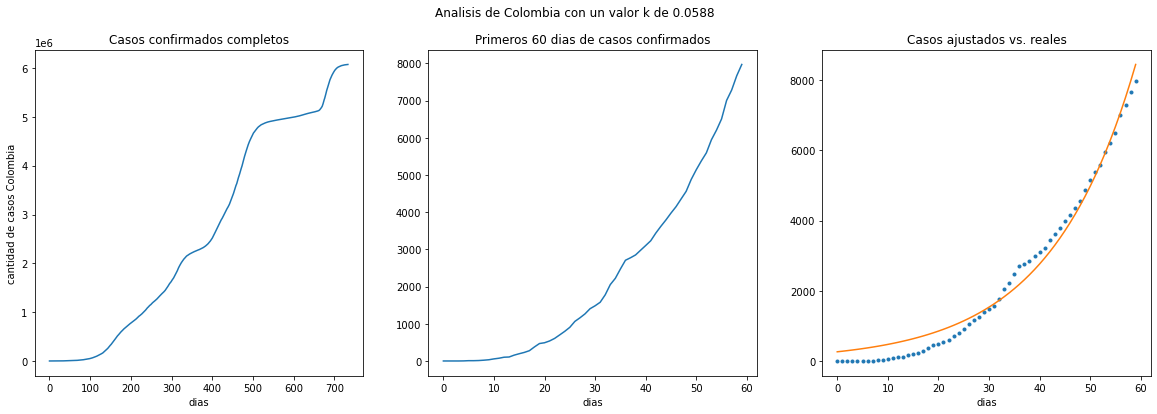

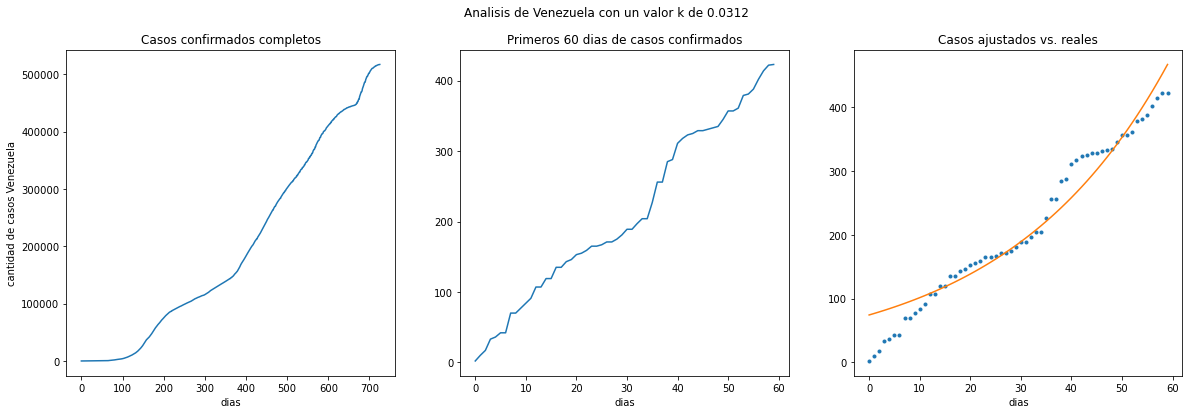

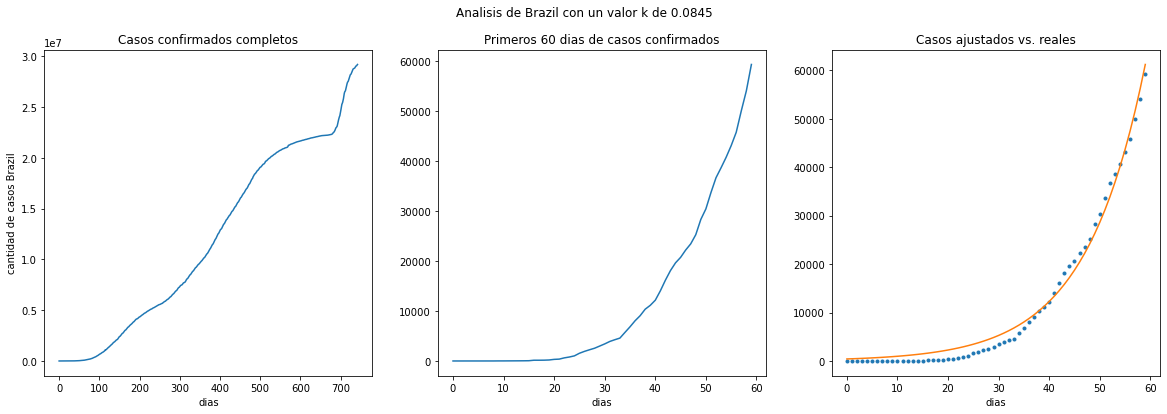

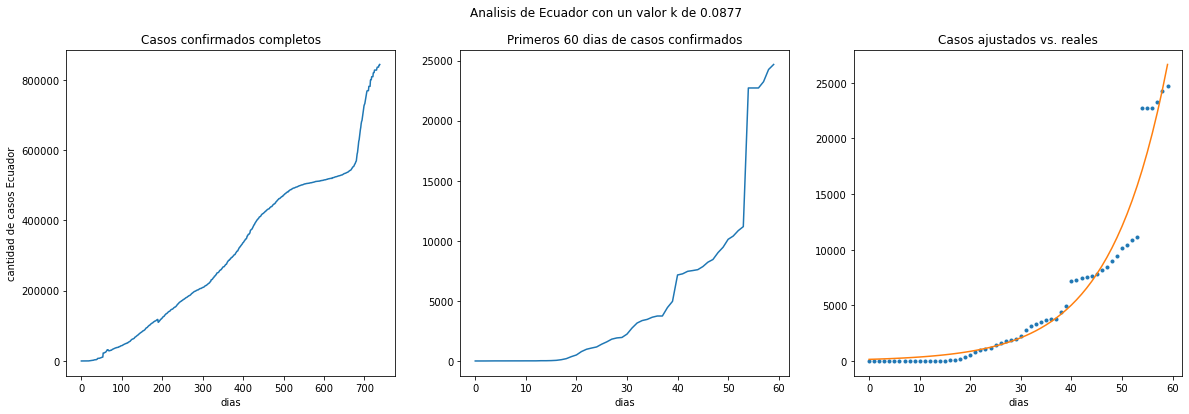

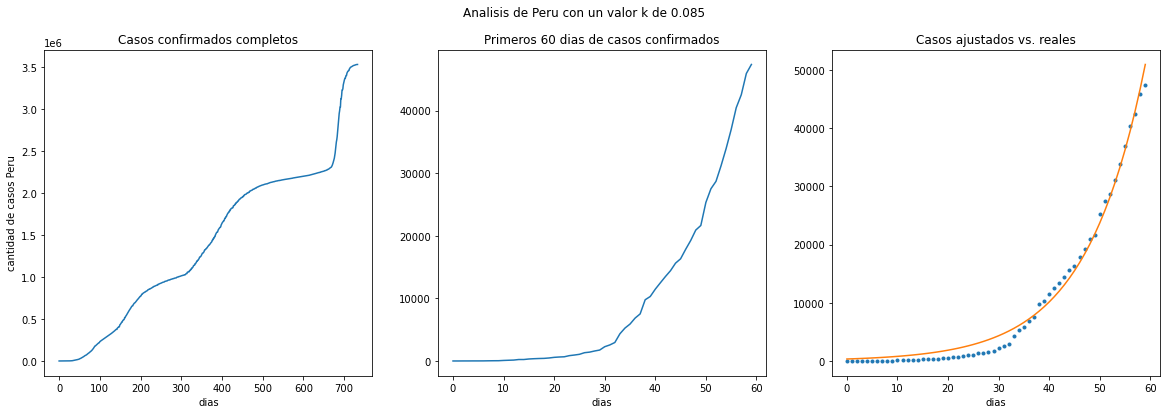

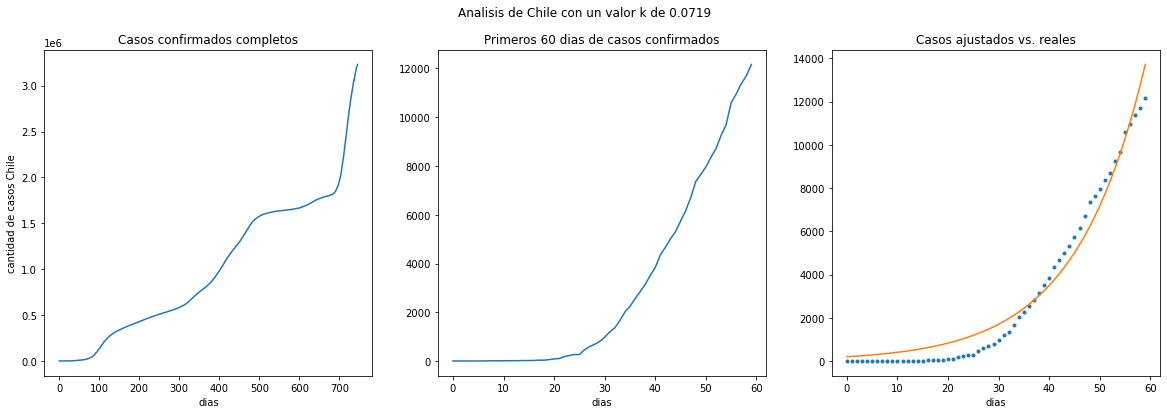

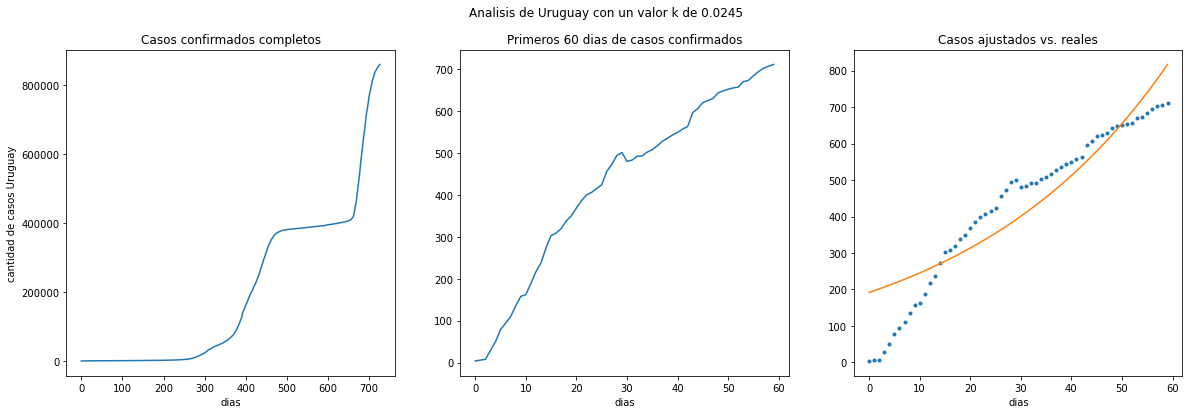

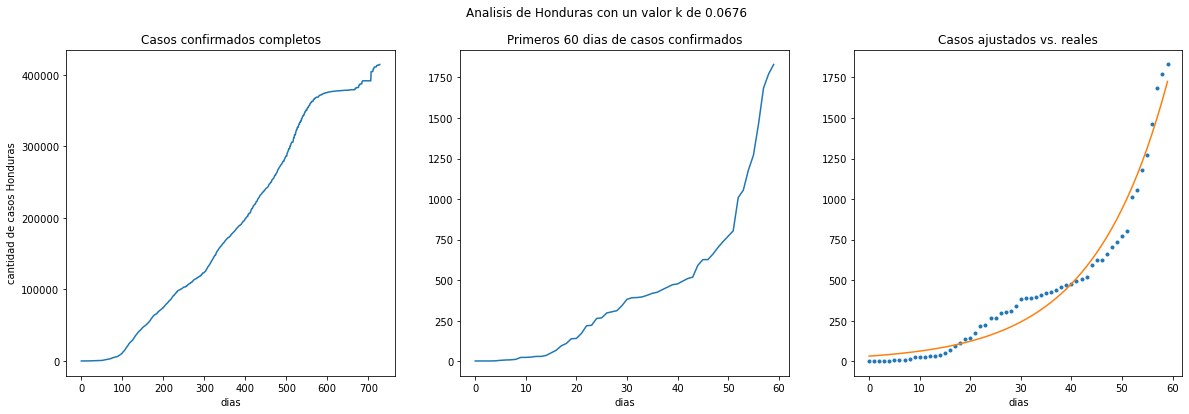

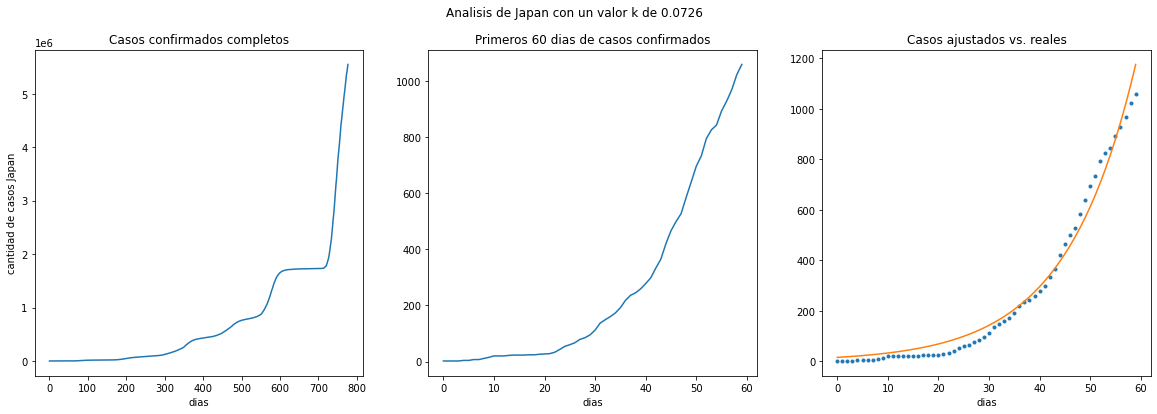

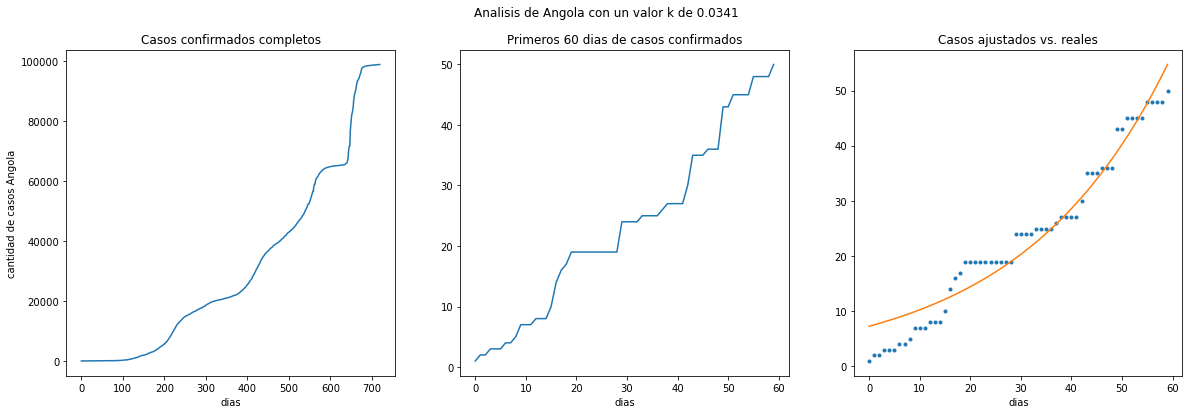

In [42]:

for country in countries:

    ind=np.where(paises==country)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].set_title('Casos confirmados completos')
    axs[0].plot(dias,casos)
    axs[0].set_xlabel('dias')
    axs[0].set_ylabel(f"cantidad de casos {country}")

    # En china los contagios arrancan desde el primer dia, y se analizaran sus primero 60 dias en donde se puede observar la tendencia del k inicial:
    casos_principio=casos[dias_limite_inf:dias_limite_sup]
    dias_principio=dias[dias_limite_inf:dias_limite_sup]
    
    axs[1].set_title(f'Primeros {dias_limite_sup} dias de casos confirmados')
    axs[1].plot(dias_principio,casos_principio)
    axs[1].set_xlabel('dias')

    #definimos función para ajustar modelo
    def exponencial(t,k,t0):
      C=np.exp(k*(t-t0))
      return C

    #ajustamos con el fin de encontrar los parametros optimos hallados (popt), y la matriz de covarianza de parametros hallados (pcov):
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio, maxfev=5000)

    k=popt[0]
    t0=popt[1]
    casos_simu=exponencial(dias_principio,k,t0)
    axs[2].set_title('Casos ajustados vs. reales')
    axs[2].plot(dias_principio,casos_principio,'.')
    axs[2].plot(dias_principio,casos_simu)
    axs[2].set_xlabel('dias')
    
    fig.suptitle(f"Analisis de {country} con un valor k de {np.round(k,4)}\n")

    paises_varios_k = np.append(paises_varios_k,k)
    
paises_varios_k

In [43]:
dist_boot_norte = bootstraping(x = paises_varios_k,
                               fun_estadistico = calcular_estadistico,
                               n_iteraciones   = 9999)

100%|███████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 17196.81it/s]


In [44]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles_norte = np.quantile(a = dist_boot_norte, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles_norte)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[0.04724343 0.07508733]


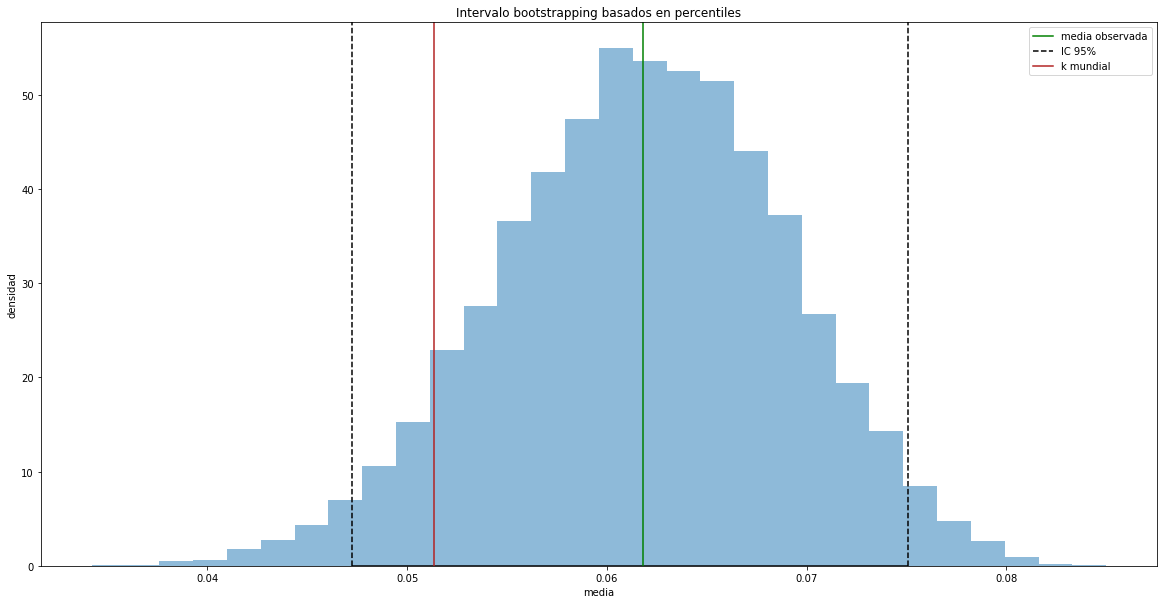

In [45]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,10))
ax.hist(dist_boot_norte, bins=30, density=True, alpha=0.5)
ax.axvline(x=paises_varios_k.mean(), color='green', label='media observada')
ax.axvline(x=cuantiles_norte[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles_norte[1], color='black', linestyle='--')
ax.axvline(x=world_k, color='firebrick', label='k mundial')
ax.hlines(y=0.001, xmin=cuantiles_norte[0], xmax=cuantiles_norte[1], color='black')
ax.set_title('Intervalo bootstrapping basados en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Gracias al ajuste de paises (principalmente del SUR) se logra llegar un valor *k* dentro del intervalo de confianza del mundo. Adicional cuando el tiempo analizado para la formula se incrementa a 90 días, los paises del norte logran calcular una *k* mucho mas aceptable dentro del intervalo.

Se pone por que se eligen los paises en ambos casos

Hacer el test de hipostesis del punto f

Los graficos generados anteriormente se usaron para la interpretación y busqueda de resultados ajustados para los futuros modelos

#### Parte B
Elige una categoría binaria que hable de políticas públicas elegidas por los países para enfrentar la pandemia

Selecciono 3 indicadores

1. k de total_cases: k_confirm
1. peso_infectados = new_cases vs population
1. hdi_score = human_development_index


In [153]:
from datetime import datetime
date_format = "%Y-%m-%d"

ultimo_registro = datetime.strptime(datos_originales[datos_originales['location'] == 'China']['date'].max(),
                                    date_format)
primer_registro = datetime.strptime(datos_originales[datos_originales['location'] == 'China']['date'].min(),
                                    date_format)

ultimo_registro_general = datetime.strptime( datos_originales['date'].max(),
                                             date_format)
primer_registro_general = datetime.strptime( datos_originales['date'].min(),
                                             date_format)

print(ultimo_registro, primer_registro)
print(ultimo_registro_general, primer_registro_general)

print((ultimo_registro_general-primer_registro_general).days)
print((primer_registro-primer_registro_general).days)

2022-03-09 00:00:00 2020-01-22 00:00:00
2022-03-09 00:00:00 2020-01-01 00:00:00
798
21


In [154]:
## Para acotar el ejercicio, se seleccionaran solo aquellos paises que hayan registrado casos antes del 2020-02-29
primeros_paises_covid = []

for p in datos_originales['location'].unique().tolist():
    if datos_originales[datos_originales['location'] == p]['date'].min() <= "2020-02-29":
        primeros_paises_covid.append(p)

In [155]:
datos_cuarentena = pd.read_csv('data/stay-at-home-covid.csv').rename(columns = {'Entity' : 'location', 'Day' : 'date'})
datos_cuarentena.head()

,location,Code,date,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [156]:
## Filtramos los datos que necesitamos analizar
datos_cuarentena = datos_cuarentena[datos_cuarentena["location"].isin(total_paises)]
datos_cuarentena = datos_cuarentena[datos_cuarentena["location"].isin(primeros_paises_covid)]

In [157]:
datos_cuarentena = datos_cuarentena[datos_cuarentena["date"] < "2020-10-31"]
datos_cuarentena["date"] = pd.to_datetime(datos_cuarentena["date"])

In [158]:
datos_cuarentena.groupby(by=[datos_cuarentena["location"],datos_cuarentena["date"].dt.month]).agg(min_restriction=("stay_home_requirements", "min"),
                                                                                                      max_restriction=("stay_home_requirements", "max"),
                                                                                                      mean_restriction=("stay_home_requirements", "mean"),
                                                                                                      mode_restriction=("stay_home_requirements", pd.Series.mode)).head(36)


min_restriction  max_restriction  mean_restriction  \
location    date                                                       
Afghanistan 1                   0                0          0.000000   
            2                   0                0          0.000000   
            3                   0                2          0.451613   
            4                   2                2          2.000000   
            5                   2                2          2.000000   
            6                   2                2          2.000000   
            7                   2                2          2.000000   
            8                   0                2          1.612903   
            9                   0                0          0.000000   
            10                  0                0          0.000000   
Albania     1                   0                0          0.000000   
            2                   0                0          0.000000   
            3                   0                2          1.225806   
            4                   2                2          2.000000   
            5                   2                2          2.000000   
            6                   1                1          1.000000   
            7                   1                1          1.000000   
            8                   1                1          1.000000   
            9                   1                1          1.000000   
            10                  1                1          1.000000   
Algeria     1                   0                0          0.000000   
            2                   0                0          0.000000   
            3                   0                3          0.870968   
            4                   2                3          2.766667   
            5                   2                2          2.000000   
            6                   2                2          2.000000   
            7                   2                2          2.000000   
            8                   2                2          2.000000   
            9                   2                2          2.000000   
            10                  2                2          2.000000   
Argentina   1                   0                0          0.000000   
            2                   0                0          0.000000   
            3                   0                3          1.258065   
            4                   2                3          2.866667   
            5                   2                2          2.000000   
            6                   2                2          2.000000   

                 mode_restriction  
location    date                   
Afghanistan 1                   0  
            2                   0  
            3                   0  
            4                   2  
            5                   2  
            6                   2  
            7                   2  
            8                   2  
            9                   0  
            10                  0  
Albania     1                   0  
            2                   0  
            3                   2  
            4                   2  
            5                   2  
            6                   1  
            7                   1  
            8                   1  
            9                   1  
            10                  1  
Algeria     1                   0  
            2                   0  
            3                   0  
            4                   3  
            5                   2  
            6                   2  
            7                   2  
            8                   2  
            9                   2  
            10                  2  
Argentina   1                   0  
            2                   0  
            3                   0  
            4        

In [159]:
datos_cuarentena.groupby(by=[datos_cuarentena["location"],datos_cuarentena["date"].dt.month]).agg(min_restriction=("stay_home_requirements", "min"),
                                                                                                      max_restriction=("stay_home_requirements", "max"),
                                                                                                      mean_restriction=("stay_home_requirements", "mean"),
                                                                                                      mode_restriction=("stay_home_requirements", pd.Series.mode)).tail(36)

min_restriction  max_restriction  mean_restriction  \
location             date                                                       
United Arab Emirates 5                   0                2          0.580645   
                     6                   0                0          0.000000   
                     7                   0                0          0.000000   
                     8                   0                0          0.000000   
                     9                   0                0          0.000000   
                     10                  0                0          0.000000   
United Kingdom       1                   0                0          0.000000   
                     2                   0                0          0.000000   
                     3                   0                2          0.935484   
                     4                   2                2          2.000000   
                     5                   1                2          1.387097   
                     6                   1                1          1.000000   
                     7                   1                1          1.000000   
                     8                   1                1          1.000000   
                     9                   1                1          1.000000   
                     10                  1                2          1.266667   
United States        1                   0                0          0.000000   
                     2                   0                0          0.000000   
                     3                   0                2          1.096774   
                     4                   2                2          2.000000   
                     5                   2                2          2.000000   
                     6                   2                2          2.000000   
                     7                   1                2          1.612903   
                     8                   1                1          1.000000   
                     9                   1                1          1.000000   
                     10                  1                2          1.433333   
Vietnam              1                   0                0          0.000000   
                     2                   0                0          0.000000   
                     3                   0                0          0.000000   
                     4                   0                2          1.400000   
                     5                   0                0          0.000000   
                     6                   0                0          0.000000   
                     7                   0                2          0.322581   
                     8                   2                2          2.000000   
                     9                   2                2          2.000000   
                     10                  0                0          0.000000   

                          mode_restriction  
location             date                   
United Arab Emirates 5                   1  
                     6                   0  
                     7                   0  
                     8                   0  
                     9                   0  
                     10                  0  
United Kingdom       1                   0  
                     2                   0  
                     3                   0  
                     4                   2  
                     5                   1  
                     6                   1  
                     7                   1  
                     8                   1  
                     9                   1  
                     10                  1  
United States        1                   0  
                     2                   0  
                     3                   2  
   

In [160]:
## El shr_score es la moda de la calificación en sus primeros 6 meses de análisis.

shr = datos_cuarentena['stay_home_requirements'].groupby(datos_cuarentena['location']).agg(pd.Series.mode).reset_index(
    name = 'shr_score').sort_values(by = 'shr_score', ascending = False)
shr

,location,shr_score
13,China,3
12,Chile,3
0,Afghanistan,2
41,Mexico,2
27,India,2
...,...,...
19,Finland,0
46,New Zealand,0
48,Norway,0
49,Oman,0


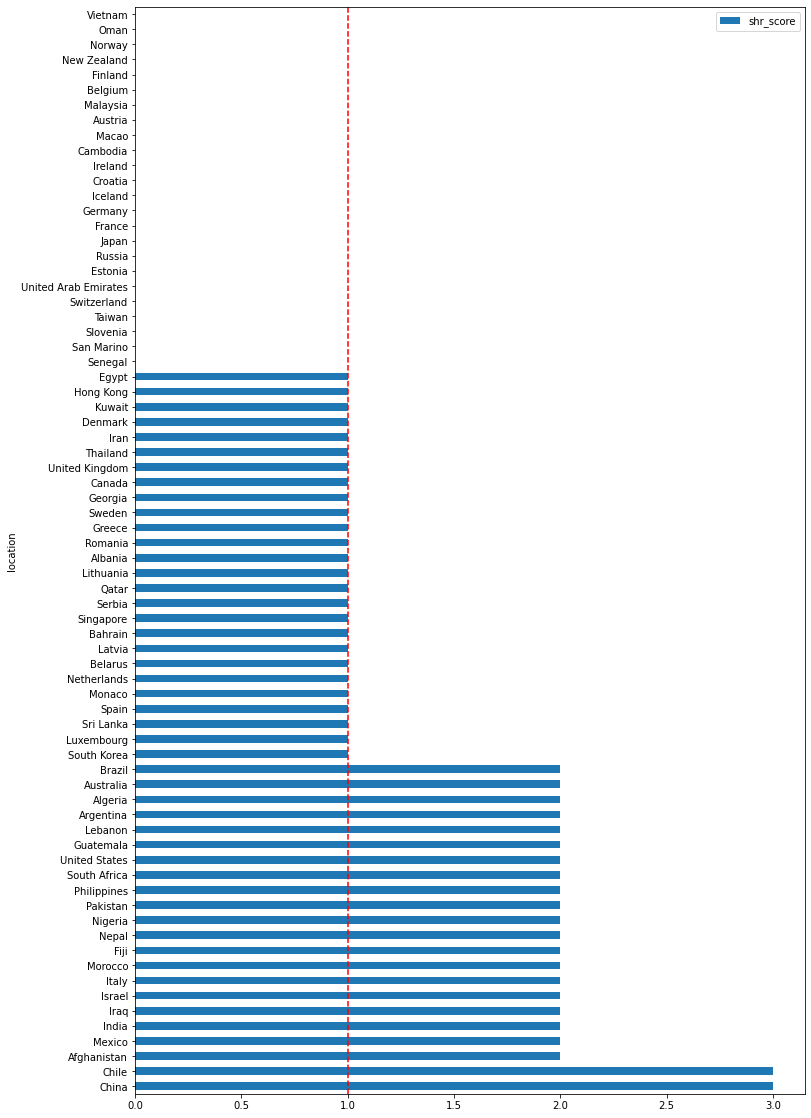

In [161]:
fig, ax = plt.subplots(figsize = (12, 20))
shr.plot('location', 'shr_score', kind = 'barh', ax = ax)
ax.axvline(1, color = 'r', linestyle = 'dashed')
plt.show()

In [162]:
muestra = 10
paises_si = shr['location'][shr['shr_score'] >= 2].sample(n=muestra).tolist()
paises_no = shr['location'][shr['shr_score'] <= 1].sample(n=muestra).tolist()

muestra_paises = paises_si + paises_no

cuarentena = [1]*muestra +[0]*muestra

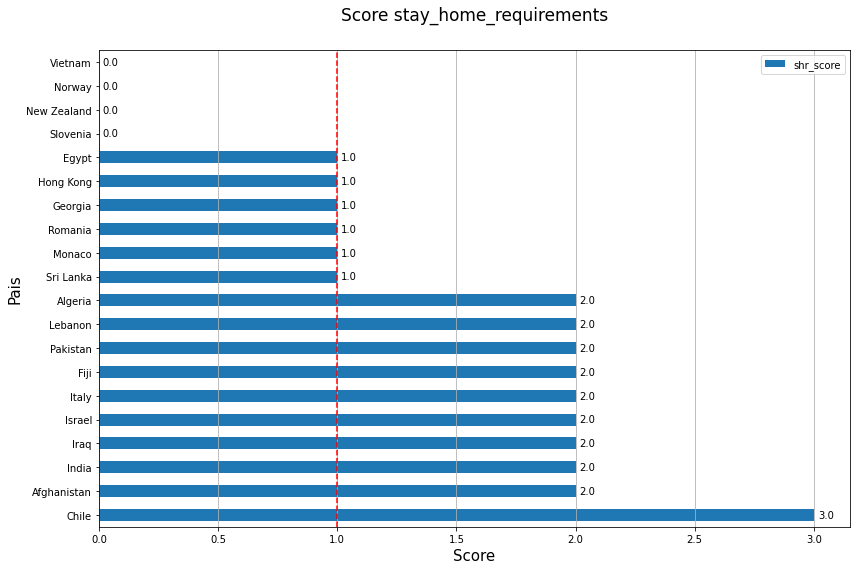

In [163]:
shr_final = shr[shr['location'].isin(muestra_paises)]

fig, ax = plt.subplots(figsize = (12, 8))
plot = shr_final.plot('location', 'shr_score', kind = 'barh', ax = ax)
ax.axvline(1, color = 'r', linestyle = 'dashed')
for p in plot.patches:
    width = p.get_width()
    plot.text(p.get_width() + 0.05, p.get_y() + p.get_height() / 2,
             '{:1.1f}'.format(width),
             ha = 'center', va = 'center')
plt.xlabel('Score', fontsize = 15)
plt.ylabel('Pais', fontsize = 15)
plt.title('Score stay_home_requirements', fontsize = 17, y = 1.05)
plt.grid(axis = 'x')
plt.tight_layout()
plt.show()

In [164]:
datos_2 = datos_originales.loc[:, ['location', 'date', 'total_cases', 'new_cases', 'population','human_development_index']]

In [165]:
datos_2 = datos_2.fillna(0)

In [166]:
# datos_2.dropna(subset = ['total_cases', 'human_development_index'], 
#                how = 'any', 
#                inplace = True)

In [167]:
datos_2 = datos_2[datos_2['location'].isin(muestra_paises)]
datos_2.head()

,location,date,total_cases,new_cases,population,human_development_index
0,Afghanistan,2020-02-24,5.0,5.0,39835428.0,0.511
1,Afghanistan,2020-02-25,5.0,0.0,39835428.0,0.511
2,Afghanistan,2020-02-26,5.0,0.0,39835428.0,0.511
3,Afghanistan,2020-02-27,5.0,0.0,39835428.0,0.511
4,Afghanistan,2020-02-28,5.0,0.0,39835428.0,0.511


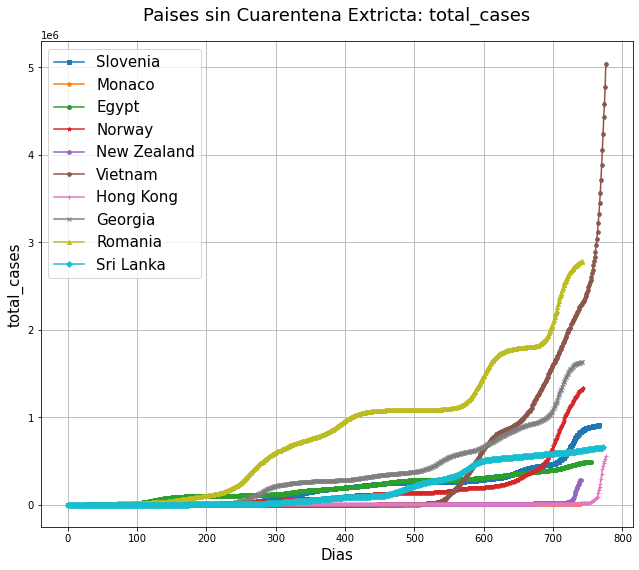

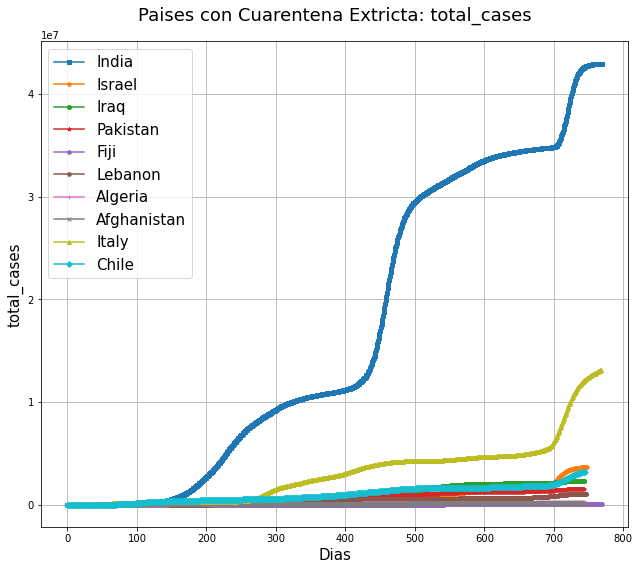

In [168]:
cols = ['total_cases']

marks = ["s","p","o","*","h",
         "H","+","x","^","D",
         "s","p","o","*","h",
         "H","+","x","^","D"]

## Paises que SI hicieron cuarentena
i = 0

for col in cols:
    fig, ax = plt.subplots(figsize = (9, 8))
    for pais in paises_no:
        casos = datos_2[col][(datos_2['location'] == pais)]
        dias = np.arange(casos.shape[0])
        plt.plot(dias, casos, label = pais, marker = marks[i], markersize = 4)
        plt.grid(b = True)
        plt.xlabel('Dias', fontsize = 15)
        plt.ylabel(f'{col}', fontsize = 15)
        plt.title(f'Paises sin Cuarentena Extricta: {col}', fontsize = 18, y = 1.03)
        plt.legend(fontsize = 15)
        i += 1

    plt.tight_layout()
    plt.show()
print('\n')


## Paises que NO hicieron cuarentena
i = 0

for col in cols:
    fig, ax = plt.subplots(figsize = (9, 8))
    for pais in paises_si:
        casos = datos_2[col][(datos_2['location'] == pais)]
        dias = np.arange(casos.shape[0])
        plt.plot(dias, casos, label = pais, marker = marks[i], markersize = 4)
        plt.grid(b = True)
        plt.xlabel('Dias', fontsize = 15)
        plt.ylabel(f'{col}', fontsize = 15)
        plt.title(f'Paises con Cuarentena Extricta: {col}', fontsize = 18, y = 1.03)
        plt.legend(fontsize = 15)
        i += 1

    plt.tight_layout()
    plt.show()

In [169]:
## Creación de DataFrame

dic_modelo = {'pais': muestra_paises,  
            'k_confirm': np.zeros(len(muestra_paises)),
            'peso_infectados': np.zeros(len(muestra_paises)),
            'hdi_min': np.zeros(len(muestra_paises)),
            'hdi_max': np.zeros(len(muestra_paises)),
            'hdi_mean': np.zeros(len(muestra_paises)),
            'cuarentena': cuarentena}

datos_modelo = pd.DataFrame(dic_modelo)
datos_modelo

,pais,k_confirm,peso_infectados,hdi_min,hdi_max,hdi_mean,cuarentena
0,India,0.0,0.0,0.0,0.0,0.0,1
1,Israel,0.0,0.0,0.0,0.0,0.0,1
2,Iraq,0.0,0.0,0.0,0.0,0.0,1
3,Pakistan,0.0,0.0,0.0,0.0,0.0,1
4,Fiji,0.0,0.0,0.0,0.0,0.0,1
5,Lebanon,0.0,0.0,0.0,0.0,0.0,1
6,Algeria,0.0,0.0,0.0,0.0,0.0,1
7,Afghanistan,0.0,0.0,0.0,0.0,0.0,1
8,Italy,0.0,0.0,0.0,0.0,0.0,1
9,Chile,0.0,0.0,0.0,0.0,0.0,1


In [170]:
paises_sin_info_2 = []

for p in muestra_paises:
    if datos_originales[datos_originales['location'] == p]['date'].min() is np.nan:
        paises_sin_info_2.append(p)

In [171]:
paises_sin_info_2

[]

In [172]:
i = 0

for pais in muestra_paises:
    
    primer_registro = datetime.strptime(datos_originales[datos_originales['location'] == pais]['date'].min(),
                                        date_format)
    
    inicio = (primer_registro - primer_registro_general).days
    
    dias = np.arange(inicio,inicio + 180)
    
    casos = datos_2['total_cases'][datos_2['location'] == pais][inicio : inicio + 180]
    
    poblacion = datos_2['population'][datos_2['location'] == pais][inicio : inicio + 180].mean()
    casos_total = datos_2['new_cases'][datos_2['location'] == pais][inicio : inicio + 180].sum()
    peso = casos_total / poblacion
    
    hdi_m = datos_2['human_development_index'][datos_2['location'] == pais][inicio : inicio + 180].min()
    hdi_M = datos_2['human_development_index'][datos_2['location'] == pais][inicio : inicio + 180].max()
    hdi_avg = datos_2['human_development_index'][datos_2['location'] == pais][inicio : inicio + 180].mean()
    
    
    popt_casos, pcov_casos = curve_fit(exponencial, dias, casos, maxfev = 6000)
    
    datos_modelo.loc[i, 'k_confirm'] = popt_casos[0]
    datos_modelo.loc[i, 'peso_infectados'] = peso
    datos_modelo.loc[i, 'hdi_min'] = hdi_m
    datos_modelo.loc[i, 'hdi_max'] = hdi_M
    datos_modelo.loc[i, 'hdi_mean'] = hdi_avg
    
    i += 1

In [173]:
datos_modelo = datos_modelo.sample(frac = 1).reset_index(drop = True)
datos_modelo

,pais,k_confirm,peso_infectados,hdi_min,hdi_max,hdi_mean,cuarentena
0,Georgia,0.051535,0.004289,0.812,0.812,0.812,0
1,Romania,0.015725,0.008948,0.828,0.828,0.828,0
2,Sri Lanka,0.013879,0.000135,0.782,0.782,0.782,0
3,Fiji,0.007995,0.000031,0.743,0.743,0.743,1
4,Pakistan,0.008108,0.001394,0.557,0.557,0.557,1
5,Chile,0.009342,0.024678,0.851,0.851,0.851,1
6,Vietnam,0.010754,0.000009,0.704,0.704,0.704,0
7,Slovenia,0.007651,0.001387,0.917,0.917,0.917,0
8,Algeria,0.011939,0.001151,0.748,0.748,0.748,1
9,India,0.031122,0.002314,0.645,0.645,0.645,1


In [174]:
num_col = datos_modelo.select_dtypes(include = 'number').drop('cuarentena', axis = 1).columns.to_list()
num_col

['k_confirm', 'peso_infectados', 'hdi_min', 'hdi_max', 'hdi_mean']

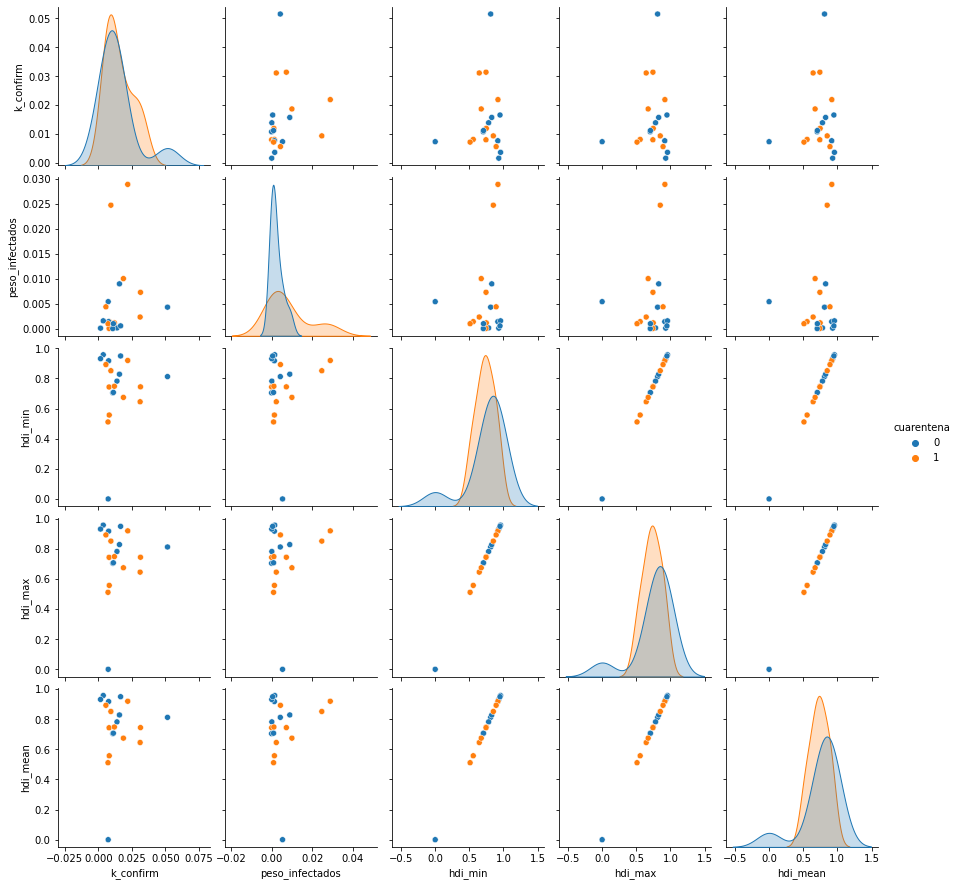

In [175]:
sns.pairplot(data = datos_modelo, hue = 'cuarentena', x_vars = num_col, y_vars = num_col)
plt.show()

In [176]:
X = datos_modelo.drop(['pais', 'cuarentena'], axis = 1)
y = datos_modelo.cuarentena

print(f'X shape: {X.shape} \n y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

print(f'X_train shape: {X_train.shape} \n X_test shape: {X_test.shape} \n y_train shape: {y_train.shape} \n y_test shape: {y_test.shape} \n')

X shape: (20, 5) 
 y shape: (20,)
X_train shape: (14, 5) 
 X_test shape: (6, 5) 
 y_train shape: (14,) 
 y_test shape: (6,) 



In [177]:
RL = LogisticRegression()
RL.fit(X_train,y_train)

LogisticRegression()

In [178]:
def Matriz_de_confusion(y_test,y_pred):
    names=["0","1"]
    cm=confusion_matrix(y_test,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",ax=ax) #fmt=".0f",
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

Regresion Logística


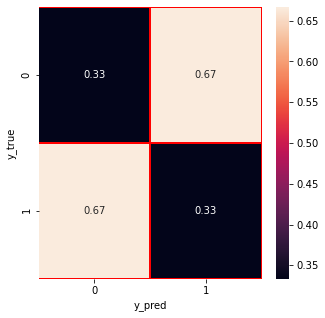

acc :  0.3333333333333333
F1 Score:  0.3333333333333333
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.33      0.33      0.33         3

    accuracy                           0.33         6
   macro avg       0.33      0.33      0.33         6
weighted avg       0.33      0.33      0.33         6



In [179]:
#Regresión Logistica:
#-----------------------
print('Regresion Logística')
y_pred_RL = RL.predict(X_test)
Matriz_de_confusion(y_pred_RL,y_test)

print("acc : ",accuracy_score(y_test, y_pred_RL))
print("F1 Score: ", f1_score(y_test ,y_pred_RL, average='macro'))
print(classification_report(y_test, y_pred_RL))

In [180]:
## Naive Bayes:

NB = GaussianNB() # Benchmark para comparar contra Linear SVC y XGboost.
NB.fit(X_train,np.array(y_train).ravel())

GaussianNB()

Gaussian Naive Bayes


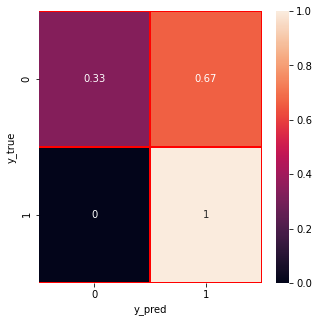

acc :  0.6666666666666666
F1 Score:  0.625
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



In [181]:
print('Gaussian Naive Bayes')
y_pred_NB = NB.predict(X_test)
Matriz_de_confusion(y_test,y_pred_NB)

print("acc : ",accuracy_score(y_test, y_pred_NB))
print("F1 Score: ", f1_score(y_test ,y_pred_NB, average='macro'))
print(classification_report(y_test, y_pred_NB))